# Exploratory Data Analysis: Second-hand Ford Vehicles
## Which variables appear to be most associated with resale price?

### Extract and Load

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# load main data, with Year as string so easy to make categorical variable
df = pd.read_csv(R'C:\Users\dariu\OneDrive\Documents\Data Science\Python Tutorials\vmlyr_exercise_2022_A.csv', dtype={'Year': str, 'Model': str})

print(df.columns)
print(df.head())
print(df.describe())
print(df.shape)

Index(['Price', 'Year', 'Mileage', 'City', 'Vin', 'Model'], dtype='object')
     Price  Year  Mileage              City                Vin         Model
0  $18021L  2020  22903.0         Fairfield  FBA136F645B6F0A10  FusionHybrid
1   $8953S  2013  92616.0      Collinsville  FB16ABDAA22090741     EscapeFWD
2  $23609D  2017  34523.0       Bloomington  F70109BACF9EFF043       EdgeSEL
3  $13762Q  2017  48969.0  Colorado Springs  F8D81B18338DC83F7    FocusSedan
4  $36324C  2020  17080.0            Olathe  F469E0851D6FC8B21   ExplorerFWD
            Mileage
count  1.093120e+05
mean   5.393903e+04
std    4.878768e+04
min   -9.999990e+05
25%    2.588375e+04
50%    4.261350e+04
75%    7.700000e+04
max    1.650780e+06
(110417, 6)


In [2]:
# check 'Vin' variable
n_vin = np.unique(df['Vin']).shape[0]
print(n_vin / df.shape[0])

1.0


In [3]:
print(df.dtypes)

Price       object
Year        object
Mileage    float64
City        object
Vin         object
Model       object
dtype: object


In [4]:
# check "Price" for weird characters at end

# remove dollar sign and last character (assuming only last char is alphanumeirc)
df['Price'] = [p[1:-1] for p in df['Price']]
df['Price'] = [np.float64(p) for p in df['Price']]
# print(df.loc[df.index[0], 'Price'])
print(df['Price'].dtype, '\n')

print(df.describe())

float64 

               Price       Mileage
count  110417.000000  1.093120e+05
mean    21907.722126  5.393903e+04
std     11460.531972  4.878768e+04
min      1755.000000 -9.999990e+05
25%     13602.000000  2.588375e+04
50%     19427.000000  4.261350e+04
75%     28681.000000  7.700000e+04
max    400460.000000  1.650780e+06


In [5]:
print(df.shape)

# load US state data and do merge
df_states = pd.read_csv(R'C:\Users\dariu\OneDrive\Documents\Data Science\Python Tutorials\vmlyr_exercise_2022_B.csv')
df = pd.merge(df, df_states, how='left', on='Vin')

print(df.columns)
print(df.shape)

(110417, 6)
Index(['Price', 'Year', 'Mileage', 'City', 'Vin', 'Model', 'State'], dtype='object')
(110417, 7)


In [7]:
df['State'] = [s.upper().lstrip() for s in df['State']]

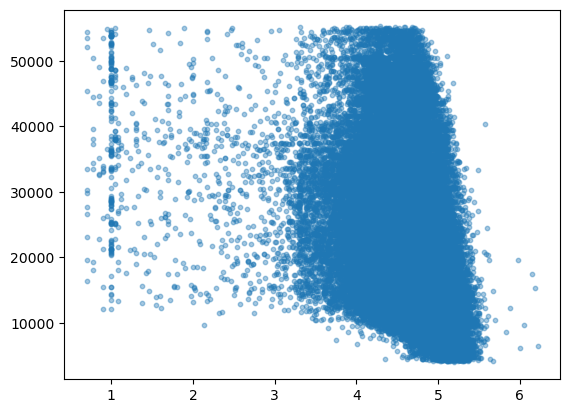

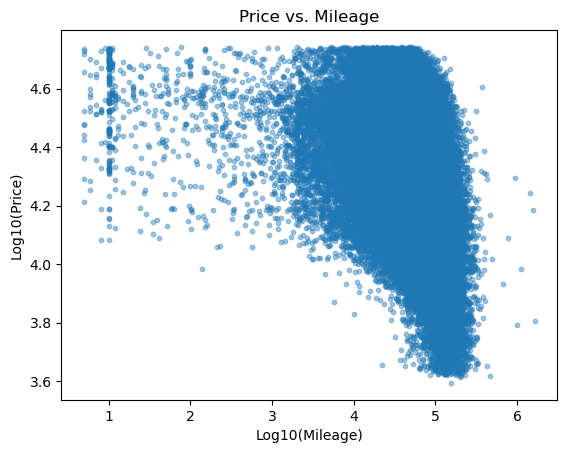

In [8]:
# remove rows erroneous Mileage values
df = df.loc[df['Mileage'] >= 0, :]

# applied Logarithmic Scale to y-axis helping explain data over a large range/different orders of magnitude

df['log_price'] = [np.log10(p) for p in df['Price']]

plt.scatter(np.log10(df['Mileage']), df['Price'], s=10, alpha=0.4)
plt.show()

plt.scatter(np.log10(df['Mileage']), df['log_price'], s=10, alpha=0.4)
plt.xlabel('Log10(Mileage)')
plt.ylabel('Log10(Price)')
plt.title('Price vs. Mileage')
plt.savefig('./price_mileage_all_log_log.pdf')



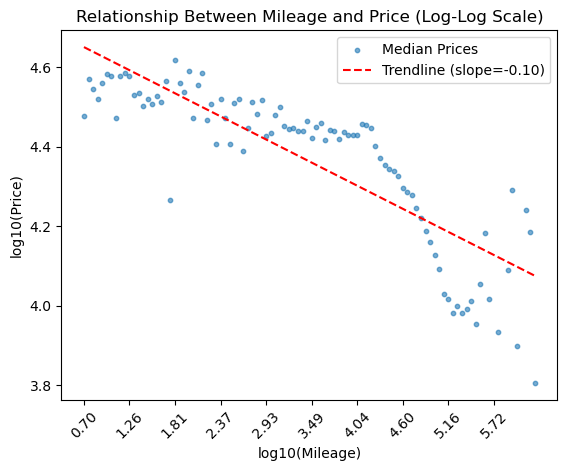

"'plt.scatter(mileage_bins[mileage_group.index-1], np.log10(mileage_group['Price']))\n\nplt.xticks(label=mileage_bins)\nplt.ylabel('log10(Price)')\nplt.xlabel('log10(Mileage)')\nplt.savefig('./average_price_mileage_log_log.pdf')"

In [14]:
from scipy.stats import linregress

# Scatter plot of mileage bins vs. log10(price)
plt.scatter(mileage_bins[mileage_group.index - 1], np.log10(mileage_group['Price']), s=10, alpha=0.6, label='Median Prices')

# Linear regression (trendline)
x = mileage_bins[mileage_group.index - 1]  # Bin centers
y = np.log10(mileage_group['Price'])  # Log10 of median prices
slope, intercept, _, _, _ = linregress(x, y)
plt.plot(x, slope * x + intercept, color='red', linestyle='--', label=f'Trendline (slope={slope:.2f})')

plt.xlabel('log10(Mileage)')
plt.ylabel('log10(Price)')
plt.title('Relationship Between Mileage and Price (Log-Log Scale)')

# X-axis tick adjustments for better readability
plt.xticks(ticks=mileage_bins[::10], labels=[f'{x:.2f}' for x in mileage_bins[::10]], rotation=45)
plt.legend()

plt.savefig('./average_price_mileage_log_log_with_trendline.pdf')
plt.show()



''''plt.scatter(mileage_bins[mileage_group.index-1], np.log10(mileage_group['Price']))

plt.xticks(label=mileage_bins)
plt.ylabel('log10(Price)')
plt.xlabel('log10(Mileage)')
plt.savefig('./average_price_mileage_log_log.pdf')'''


### Data quality issues:
- Year with currency and alphanumeric characters
- States and aren't all uppercase- not really an issue
- Mileages have negative values - erroneous
- Cities have mix of all uppercase, and lowercase
- Models are too granular for holistic analysis

In [21]:
def plot_average(df, group_label, ylabel, average_func=np.nanmean,
                 plot_scatter=False, plot_hist=True,
                sort_price=False):
    """
    function to group by a given label (eg City, State, Year) and plot
    mean (by default, use `average_func` kwarg to use eg median) Price in scatter or histogram
    """
    group_ = df.groupby(group_label).agg({'Price': average_func})
    
    if sort_price:
        group_ = group_.sort_values('Price')
    
    if plot_scatter:
        plt.scatter(group_.index, group_['Price'])
        plt.ylabel(ylabel)
        plt.xlabel(group_label)
        plt.xticks(rotation=45)
        plt.show()
    
    if plot_hist:
        plt.hist(np.log10(group_['Price']), bins=100)
        plt.ylabel('Count')
        plt.xlabel('log({})'.format(ylabel))
        plt.show()

    
    return group_

CITY


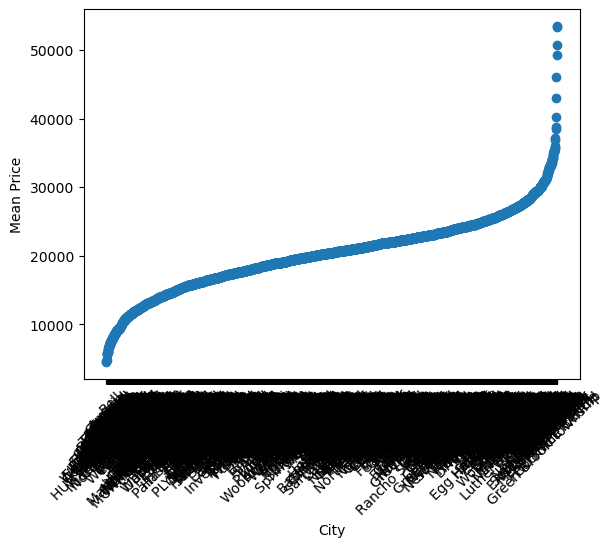

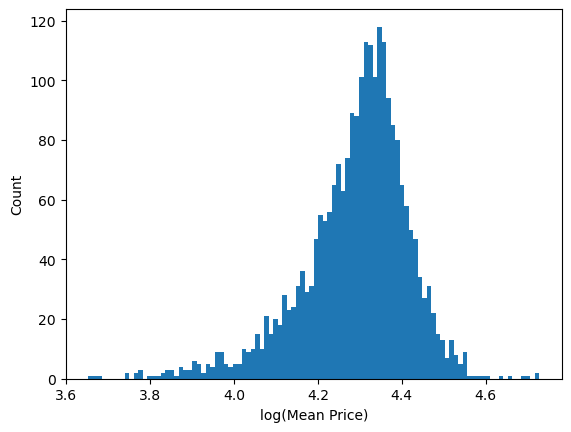

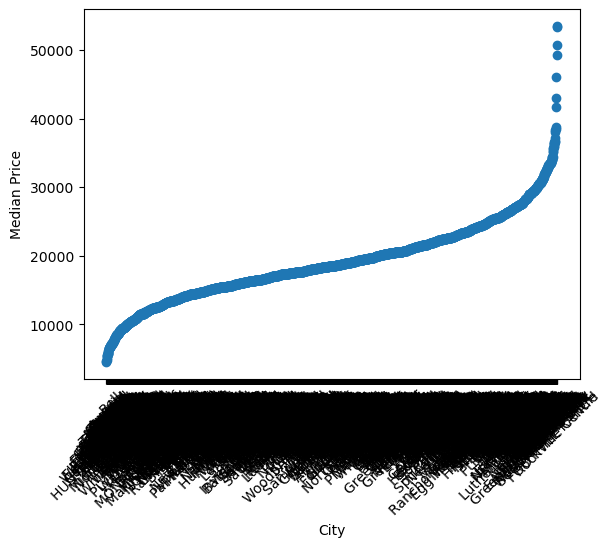

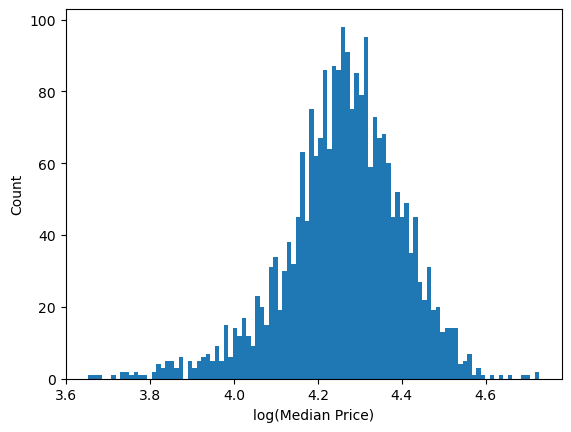

STATE


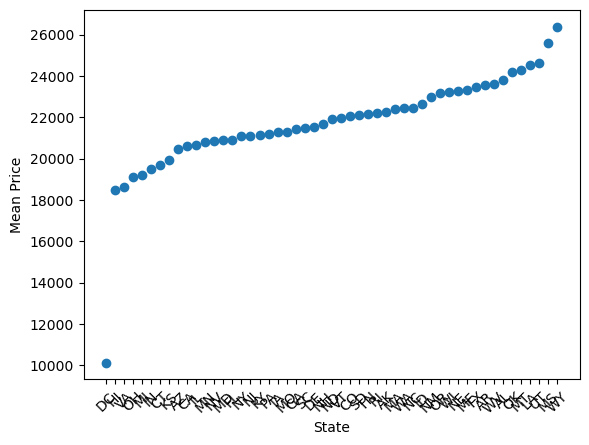

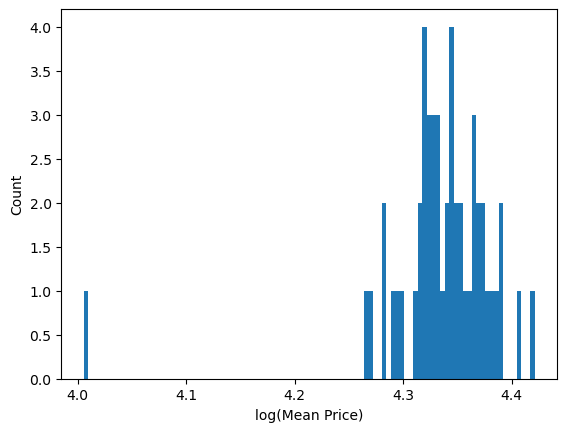

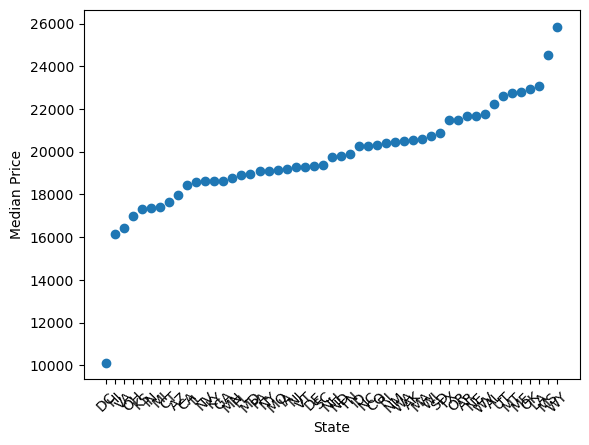

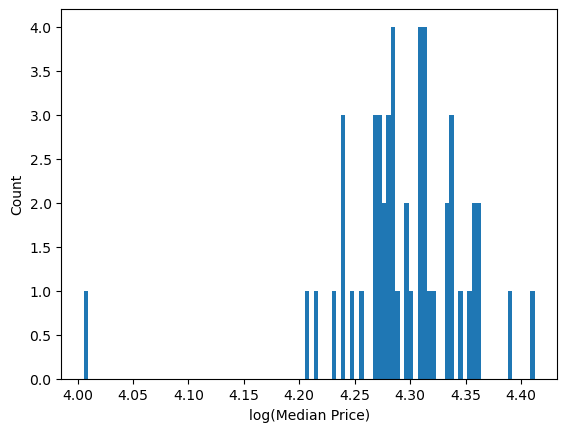

YEAR


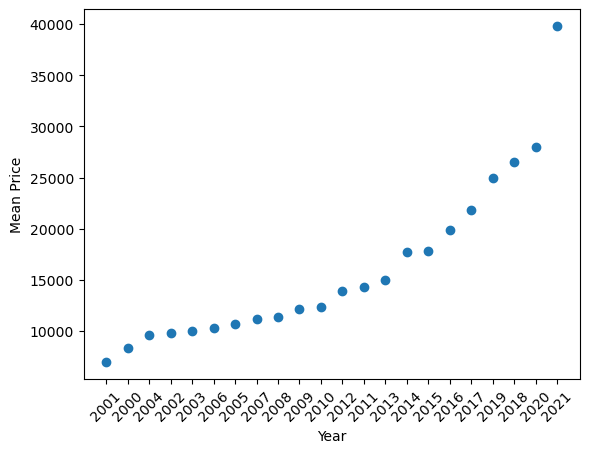

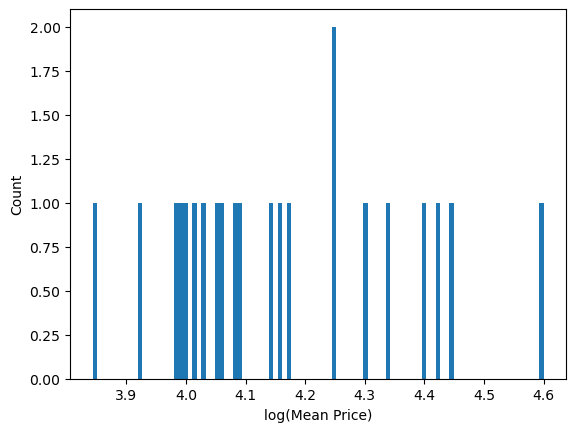

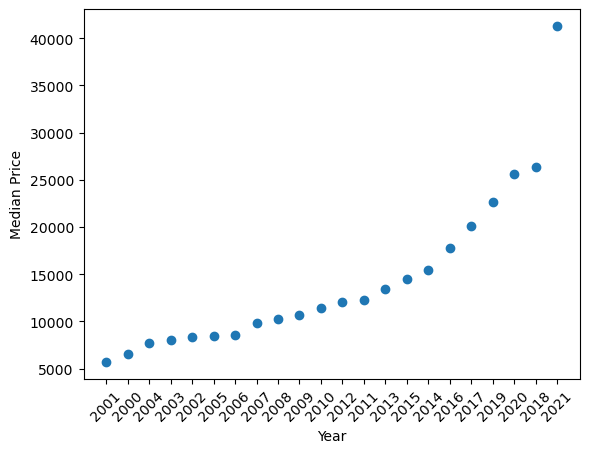

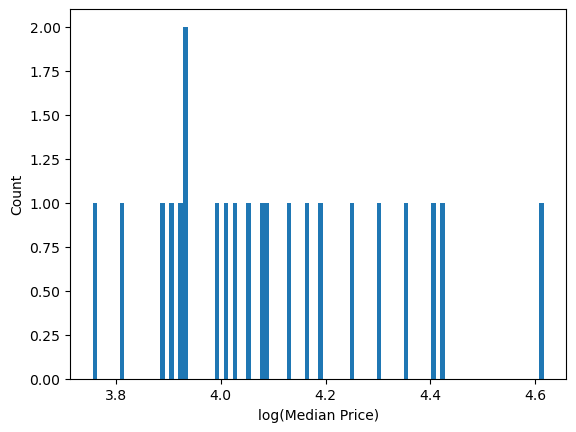

In [22]:
avgs = []

for c in ['City', 'State', 'Year']:
    print(c.upper())
    plot_scatter = True if c != 'City' else False
    sort_price = True
    plotex_hist = True if c == 'City' else False
    
    plot_average(df, c, 'Mean Price', plot_scatter=True, plot_hist=True, sort_price=sort_price)
    avgs.append(plot_average(df, c, 'Median Price', np.nanmedian, plot_scatter=True, plot_hist=True, sort_price=sort_price))

In [17]:
# check the values of city in a given state
for state in np.unique(df['State']):
    print(state)
    state_df = df.loc[df['State'] == state, :]
    cities = np.unique(state_df['City'])
    print(cities)
    n_cities = cities.shape[0]
    print(n_cities, '\n')

# clean the data if necessary (eg two cities for one, states?)
#   - some labels for cities have different values... eg Fort Myers, Ft Myers, Ft. Myers

AK
['Anchorage' 'Eagle River' 'Fairbanks' 'Wasilla' 'anchorage']
5 

AL
['Albertville' 'Alexander City' 'Anniston' 'Athens' 'Atmore' 'Auburn'
 'Bay Minette' 'Bessemer' 'Birmingham' 'Boaz' 'Brewton' 'Calera'
 'Childersburg' 'Clanton' 'Cullman' 'DAPHNE' 'DOTHAN' 'Dadeville' 'Daphne'
 'Decatur' 'Dothan' 'Elba' 'Enterprise' 'Florence' 'Foley' 'Fort Payne'
 'Gadsden' 'Gardendale' 'Hoover' 'Hueytown' 'Huntsville' 'Huntville'
 'Jackson' 'Jasper' 'Loxley' 'Mobile' 'Montgomery' 'Muscle Shoals'
 'Oneonta' 'Opelika' 'Ozark' 'Pelham' 'Phenix City' 'Prattville'
 'Rainbow City' 'Scottsboro' 'Selma' 'Sylacauga' 'Sylacuaga' 'Talladega'
 'Tallassee' 'Thomasville' 'Trussville' 'Tuscaloosa' 'Tuscumbia']
55 

AR
['Arkadelphia' 'Bentonville' 'Cabot' 'Conway' 'Fayetteville' 'Fort Smith'
 'Harrison' 'Heber Springs' 'Jacksonville' 'Jonesboro' 'Little Rock'
 'Marion' 'North Little Rock' 'Rogers' 'Sherwood' 'Siloam Springs'
 'Springdale' 'Van Buren']
18 

AZ
['Apache Junction' 'Avondale' 'Buckeye' 'Bullhead Cit

['Ankeny' 'Boone' 'Cedar Falls' 'Cedar Rapids' 'Clive' 'Council Bluffs'
 'DAVENPORT' 'Davenport' 'Des Moines' 'Eldridge' 'Grimes' 'Harlan'
 'INDIANOLA' 'Iowa City' 'Kalona' 'Lake City' 'Marion' 'Missouri Valley'
 'Oskaloosa' 'Ottumwa' 'Sioux City' 'Urbandale']
22 

ID
['Boise' 'Burley' 'Caldwell' "Coeur d'Alene" 'Garden City' 'Hayden'
 'Idaho Falls' 'Moscow' 'Nampa' 'Pocatello' 'Post Falls' 'Rexburg' 'Sagle'
 'Twin Falls']
14 

IL
['Addison' 'Algonquin' 'Alsip' 'Alton' 'Antioch' 'Arlington Heights'
 'Aurora' 'Barrington' 'Belleville' 'Bensenville' 'Berwyn' 'Bloomington'
 'Blue Island' 'Bourbonnais' 'Bradley' 'Bridgeview' 'Buffalo Grove'
 'Burbank' 'Burr Ridge' 'Calumet' 'Calumet City' 'Carbondale' 'Carlock'
 'Carol Stream' 'Channahon' 'Chicago' 'Collinsville' 'Columbia'
 'Country Club Hills' 'Countryside' 'Crest hill' 'Crystal Lake' 'Danville'
 'Decatur' 'Des Plaines' 'Downers Grove' 'East Dundee' 'Elgin'
 'Elk Grove Village' 'Elmhurst' 'Evanston' 'Fairview Heights'
 'Forest Park' 'Fox

['Carson City' 'Elko' 'Fallon' 'Fernley' 'Henderson' 'Las Vegas' 'Pahrump'
 'Reno' 'Winnemucca' 'Yerington']
10 

NY
['Albany' 'Amherst' 'Amityville' 'Amsterdam' 'BAY SHORE' 'BRONX' 'Batavia'
 'Bay Shore' 'Bayshore' 'Bayside' 'Blauvelt' 'Bohemia' 'Brewster'
 'Brockport' 'Bronx' 'Brooklyn' 'Canandaigua' 'Canton' 'Carmel'
 'Cheektowaga' 'Cicero' 'Clayton' 'Comstock' 'Cortlandt' 'Cortlandt Manor'
 'Depew' 'Dunkirk' 'East Meadow' 'East Rochester' 'East Syracuse'
 'Elmhurst' 'Falconer' 'Farmingdale' 'Farmington' 'Freeport'
 'Grand Island' 'Great Neck' 'Greenvale' 'Hamburg' 'Hempstead'
 'Huntington' 'Huntington Station' 'Inwood' 'Jamaica' 'Kingston'
 'Lackawanna' 'Lake Katrine' 'Larchmont' 'Latham' 'Levittown' 'Liberty'
 'Liverpool' 'Lockport' 'Long Island  City' 'Long Island City' 'Lynbrook'
 'Malta' 'Mamaroneck' 'Massapequa' 'Mechanicville' 'Medford'
 'Middle Village' 'Middletown' 'Mongaup Valley' 'Monticello' 'Mount Kisco'
 'NEW HAMPTON' 'Nanuet' 'Nelliston' 'New Rochelle' 'New Windsor'
 

In [ ]:
#state_group = plot_average(df, c, 'Median Price', np.nanmedian, plot_scatter=True, plot_hist=True, sort_price=sort_price)

In [ ]:
# plot min/max 5 with colour corresponding to state

import matplotlib.patches as mpatches
from matplotlib.cm import tab20b

city_avgs = avgs[0]

# Extracting the min and max 5 rows
min_5 = city_avgs.loc[city_avgs.index[:5], :]
max_5 = city_avgs.loc[city_avgs.index[-5:], :]

# Getting states corresponding to min and max 5
min_states = [np.unique(df.loc[df['City'] == c, 'State'])[0] for c in min_5.index]
max_states = [np.unique(df.loc[df['City'] == c, 'State'])[0] for c in max_5.index]

# Adding 'State' column to min_5 and max_5
min_5['State'] = min_states
max_5['State'] = max_states

# Get lists of included states and corresponding color index
unique_incl_states = np.unique(np.concatenate([min_states, max_states]))
state_dict = {k: v for k, v in zip(unique_incl_states, range(len(unique_incl_states)))}
num_categories = len(unique_incl_states)
colors = [tab20b(float(i) / num_categories) for i in range(num_categories)]

min_colors = [colors[state_dict[s]] for s in min_5['State']]
max_colors = [colors[state_dict[s]] for s in max_5['State']]

# Plot for min_5
fig, ax = plt.subplots()
ax.scatter(min_5.index, min_5['Price'], c=min_colors)
ax.set_ylabel('Median Price')
ax.set_xlabel('City')
ax.set_title('Cities with minimum median resale value')
plt.xticks(rotation=45)

patches = [mpatches.Patch(color=colors[state_dict[s]], label=s) for s in min_states]
ax.legend(handles=patches)
plt.savefig('min5_cities_median_price_colored_state.pdf')
plt.show()

# Plot for max_5
fig, ax = plt.subplots()
ax.scatter(max_5.index, max_5['Price'], c=max_colors)
ax.set_ylabel('Median Price')
ax.set_xlabel('City')
ax.set_title('Cities with maximum median resale value')
plt.xticks(rotation=45)

patches = [mpatches.Patch(color=colors[state_dict[s]], label=s) for s in max_states]
ax.legend(handles=patches)
plt.savefig('max5_cities_median_price_colored_state.pdf')
plt.show()


In [ ]:
# Plot for min_5
fig, ax = plt.subplots()
ax.scatter(min_5.index, min_5['Price'], c=min_colors)
ax.set_ylabel('Median Price')
ax.set_xlabel('City')
ax.set_title('Cities with minimum median resale value')
plt.xticks(rotation=45)

patches = [mpatches.Patch(color=colors[state_dict[s]], label=s) for s in min_states]
ax.legend(handles=patches)
plt.savefig('min5_cities_median_price_colored_state.pdf')
plt.show()

# Plot for max_5
fig, ax = plt.subplots()
ax.scatter(max_5.index, max_5['Price'], c=max_colors)
ax.set_ylabel('Median Price')
ax.set_xlabel('City')
ax.set_title('Cities with maximum median resale value')
plt.xticks(rotation=45)

patches = [mpatches.Patch(color=colors[state_dict[s]], label=s) for s in max_states]
ax.legend(handles=patches)
plt.savefig('max5_cities_median_price_colored_state.pdf')
plt.show()

In [ ]:
state_avgs = avgs[1]
# print(state_avgs)
n = 10

plt.scatter(state_avgs.index[:n], state_avgs.loc[state_avgs.index[:n], 'Price'])
plt.ylabel('log10(Price)')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.title('States with minimum median resale value')
plt.savefig('logPrice_logMileage_min10States.pdf')

plt.scatter(state_avgs.index[-n:], state_avgs.loc[state_avgs.index[-n:], 'Price'])
plt.ylabel('log10(Price)')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.title('Top & Bottom 10 States - Median Resale Value')
plt.savefig("logPrice_logMileage_max10States.pdf")

In [ ]:
print(avgs[2].index)
fig, ax = plt.subplots()
ax.scatter(avgs[2].index, avgs[2]['Price'])
ax.set_xticks(avgs[2].index[::3])
ax.set_xlabel('Year')
ax.set_ylabel('Median resale value')
plt.show()

print(avgs[2].index)
fig, ax = plt.subplots()
ax.scatter(avgs[2].index, np.log10(avgs[2]['Price']))
ax.set_xticks(avgs[2].index[::3])
ax.set_xlabel('Year')
ax.set_ylabel('log10 Median resale value')
plt.savefig('log_median_price_by_year.pdf')

In [ ]:
# avgs[0]
# same for model
avg_price_mileage = plot_average(df, 'Model', 'Median Price', average_func=np.nanmedian, plot_scatter=True, plot_hist=False, sort_price=True)


In [ ]:
# basic desc stats for each cat variable
avgs[0].describe().to_csv('./desc_statistics_city_median_price.csv') # City
avgs[1].describe().to_csv('./desc_statistics_state_median_price.csv') # State
avgs[2].describe().to_csv('./desc_statistics_year_median_price.csv') # Year

In [ ]:
# attempt to clean the 'model' field - creating less granular data
# eventually works for most cases but several edge cases remain and
# several base models are omitted e.g. "fiesta" and "taurus"
print(np.unique(df['Model']))

# get indices of all capital characters in each model string entry
capitals = [[m.isupper() for m in model] for model in df['Model']]

# store "base" group 
base_model = np.empty(len(capitals), dtype=str)

for i, m in enumerate(df['Model']):
#     print(m)
#     print(np.where(capitals[i])[0], )
#     print(m[:5])

    # assign truncated model value if needed
    if len(np.where(capitals[i])[0]) > 1:
        second_capital_ind = np.where(capitals[i])[0][1]

        if i < 10:
            
            print(second_capital_ind)
            print(m[:second_capital_ind])
        base_model[i] = m[:second_capital_ind]
    else:
        base_model[i] = m
#     print(ba==se_model[i])
#     print(np.where(capitals[i])[0][1])

# store in dataframe
df['clean_attempt_one'] = base_model
    
print(np.unique(df['clean_attempt_one']))
      # len(capitals)

In [ ]:
# attempts a different more successful approach using RegEx 
import re

print("Unique models before cleaning:", np.unique(df['Model']))

def clean_model_name(model):
    # find all positions of uppercase letters
    capital_indices = [m.start() for m in re.finditer(r'[A-Z]', model)]
    
    # truncate the model name if it has more than one uppercase letter
    if len(capital_indices) > 1:
        base_model = model[:capital_indices[1]]
    else:
        base_model = model

    # temove trailing numbers, non-alphabetic characters, and "dr" after the first uppercase letter
    base_model = re.sub(r'[^A-Za-z]', '', base_model)
    base_model = re.sub(r'dr$', '', base_model, flags=re.IGNORECASE)
    
    return base_model

# Apply the cleaning function to the 'Model' column
df['base_model'] = df['Model'].apply(clean_model_name)

print("Unique base models after cleaning:", np.unique(df['base_model']))
print(df[['base_model', 'Model']].head())


In [ ]:
# do simple linear regression (OLS) on each variable in turn - look at R^2 etc
# - ideally then figure out if codependencies between variables, what form of multivariable model is best etc

## Year

In [ ]:
# OLS for Year
data = pd.get_dummies(df, columns=['Year'])
# print(data.columns)
# print(data.columns.shape)

# independent data
independent = data.columns[data.columns != 'Price']
independent = [i for i in independent if i[0] == 'Y']
# print(independent)
X = data.loc[:, independent]
print(X.dtypes)

# target data
Y = np.log10(data['Price'])
print(Y.dtypes)

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

In [ ]:
def average_ols(df, num_vals=False, log=False):
    

    
    if num_vals:
        X = [int(y) for y in df.index]
    else:
        X = df.index
        
    if not log:
        Y = df['Price']
    else:
        Y = np.log10(df['Price'])
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    
    return model

In [ ]:
# OLS for year based on average prices
model_year = average_ols(avgs[2], num_vals=True, log=True)
print(model_year.summary())

## City

In [ ]:
'''# OLS for City
data = pd.get_dummies(df, columns=['City'])
print(data.columns)
print(data.columns.shape)

# independent data
independent = data.columns[data.columns != 'Price']
independent = [i for i in independent if i[0] == 'C']
# print(independent)
X = data.loc[:, independent]
print(X.dtypes)

# target data
Y = data['Price']
print(Y.dtypes)

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())'''

In [ ]:
# Define plot_average_no_plot function
def plot_average_no_plot(df, group_label, ylabel, average_func=np.nanmean, sort_price=False):
    group_ = df.groupby(group_label).agg({'Price': average_func}).reset_index()
    if sort_price:
        group_ = group_.sort_values('Price')
    return group_

# Generate averages for City, State, and Year without plotting
avgs_no_plot = []
for c in ['City', 'State', 'Year']:
    avgs_no_plot.append(plot_average_no_plot(df, c, 'Median Price', np.nanmedian, sort_price=True))

# Define the average_ols function
def average_ols(df, group_label, log=False):
    X = pd.get_dummies(df[group_label], drop_first=True)  # Convert group labels to dummy variables, drop first to avoid multicollinearity
    Y = df['Price']
    
    if log:
        Y = np.log10(Y)
    
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    
    return model

# Perform OLS regression for city averages
model_city_fixed = average_ols(avgs_no_plot[0], 'City', log=True)
print(model_city_fixed.summary())

## Car Base Model

In [ ]:
# Create dummy variables for 'base_model'
data = pd.get_dummies(df, columns=['base_model'])
print(data.columns)
print(data.columns.shape)

# Independent data
independent = data.columns[data.columns != 'Price']
independent = [i for i in independent if i.startswith('base_model')]
print(independent)
X = data.loc[:, independent]
print(X.dtypes)

# Target data
Y = data['Price']
print(Y.dtypes)

# Fit the OLS model
model = sm.OLS(Y, X).fit()
model_summary = model.summary()

print(model_summary)

In [ ]:
avg_price_mileage

## Mileage

In [ ]:
# Independent data
independent = data.columns[data.columns != 'Price']
independent = [i for i in independent if i.startswith('Mileage')]
print(independent)
X = data.loc[:, independent]
print(X.dtypes)

# Target data
Y = data['Price']
print(Y.dtypes)

# Ensure all variables are numeric and check for NaNs or inf values
#X = X.apply(pd.to_numeric, errors='coerce')
#Y = pd.to_numeric(Y, errors='coerce')
#X = sm.add_constant(X)

# Ensure the data is properly formatted for OLS
X = np.asarray(X, dtype=np.float64)
Y = np.asarray(Y, dtype=np.float64)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(Y, X).fit()
model_summary = model.summary()

print(model_summary)

In [ ]:
# OLS for mileage based on average prices
#model_mileage = average_ols(avgs[1], num_vals=True, log=True)
#print(model_mileage.summary())

In [ ]:
# use "model checking" to see if linear model is good assumption - diagnostic plots
#   - see Applied stat modelling notes - Chapter 2 slide 31
#   - double check from previous slides in these notes whether the residuals are correctly calculated etc

## All Car Models

In [ ]:
# Create dummy variables for 'Model_base'
data = pd.get_dummies(df, columns=['Model'])
print(data.columns)
print(data.columns.shape)

# Independent data
independent = data.columns[data.columns != 'Price']
independent = [i for i in independent if i.startswith('Model')]
print(independent)
X = data.loc[:, independent]



# Target data
Y = data['Price']
print(Y.dtypes)


# Add a constant term
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(Y, X).fit()
model_summary = model.summary()

print(model_summary)


In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lmplot(x='Mileage', y='log_price', data=df, height=6, aspect=2)
plt.title('Linear Regression: Mileage vs. Log(Price)')
plt.xlabel('Mileage')
plt.ylabel('Log(Price)')
plt.show()


## Multi-linear regression

In [ ]:
# Create dummy variables for 'base_model', 'Year', and 'City'
data = df.drop(columns=['Vin'])
data = pd.get_dummies(df, columns=['base_model', 'Year', 'City'], drop_first=True)

# Prepare independent and dependent variables
independent_vars = ['Mileage'] + [col for col in data.columns if col.startswith('base_model_') or col.startswith('Year_') or col.startswith('City_')]
X = data[independent_vars]
Y = data['log_price']

X = sm.add_constant(X)

# Fit the multi-linear regression model
model = sm.OLS(Y, X).fit()
print(model.summary())

In [ ]:
p_values = model.pvalues
coefficients = model.params

# Combine the p-values and coefficients into a df for easier manipulation
results = pd.DataFrame({'coefficients': coefficients, 'p_values': p_values})

# Sort by p-values in ascending order (most significant first)
sorted_results = results.sort_values(by='p_values', ascending= True)
top_25_results = sorted_results.head(50)
# Display the sorted coefficients and their p-values
print("\nCoefficients ordered by significance:")
print(top_25_results)

## Insights

1. The year of the car is a significant predictor of resale price. Newer models (e.g., 2018, 2019) tend to have higher resale prices, as indicated by the positive coefficients.
<br>

2. The base models are the next largest predictor, vintage (Thunderbird), trucks/pickups (Super, F-150/250) and SUVs (Flex) have higher resale prices whilst the Fiesta, a budget model has a negative coeffecient.
<br>

3. Mileage is also a notable predictor, the negative coefficient shows that as mileage increases, the resale price decreases, aligns with market expectations on reliability, performance, maitenance costs etc.
<br>

4. Cities are less significant predictors, below the 25 most significant IVs, the city of Ridgewood indicates lower resale prices whilst Lemont has a higher resale price association. However their p-values are well out of the range of statistical significanc for the overall prediction of resale price.

In [ ]:
# Create dummy variables for 'base_model', 'Year'
data = df.drop(columns=['Vin'])
data = pd.get_dummies(df, columns=['base_model', 'Year'], drop_first=True)

# Prepare independent and dependent variables
independent_vars = ['Mileage'] + [col for col in data.columns if col.startswith('base_model_') or col.startswith('Year_')]
X = data[independent_vars]
Y = data['log_price']

X = sm.add_constant(X)

# Fit the multi-linear regression model
model = sm.OLS(Y, X).fit()
print(model.summary())

## Improving the Model
- Removing Cities from the model doesn't impact how well the model fits the data and produces a simpler benchmark model with fewer variables which may perform better.
<br>

- From an explanatory standpoint the directional signs of including city don't make sense: two cities with the largest weighting: Ridgewood a very high median household income has a significant negative weighting whilst Lemont, which has a higher income than the national mean but not nearly as high as Ridgewood, actually has a strong positive weighting.
<br>

- Furthermore the p-values for the above assume the null hypothesis is true and thus are not statistically significant.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
model = sm.OLS(Y_train, X_train).fit()
print(model.summary())


## Model Testing

In [ ]:
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"\nMean Squared Error: {mse}")
print(f"R-squared: {r2}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Y_test.values, label='Actual Values', color='blue')
plt.plot(Y_pred.values, label='Predicted Values', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Log(Price)')
plt.legend()
plt.show()

In [ ]:
# Visualise MSE as a scatter plot with line of best fit
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, alpha=0.7)
plt.plot(Y_test, Y_test, color='red', linewidth=2, label='Actual Trend')  # Line of best fit
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(loc='upper left') 
plt.show()

- The mean squared error is close to 0 and the Coeffecient correlation (R^2) is greater than 0.85 which is acceptable for model accuracy.